# Replicating Audio Texture Synthesis (by Dimitry Ulyanov)
- Original Source: [Ulyanov's Github](https://github.com/DmitryUlyanov/neural-style-audio-torch)
- Article: [Ulyanov's Blog](https://dmitryulyanov.github.io/audio-texture-synthesis-and-style-transfer/)

In [1]:
import utils
import librosa
import matplotlib.pyplot as plt
import numpy as np

import importlib
from pathlib import Path

In [2]:
DATASET = Path("/home/slas3r/courses/dl/project/music_st/fma")

In [3]:
tfile = DATASET / "000/000002.mp3"

In [4]:
wave, sr = librosa.load(tfile)

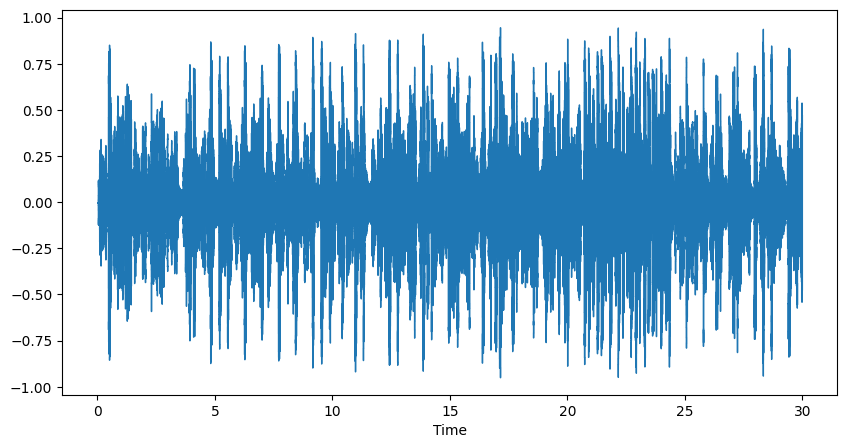

In [5]:
fig = plt.figure(figsize=(10, 5))
librosa.display.waveshow(wave)
plt.show()

### STFT

In [ ]:
spectrum, phase = utils.stft_wave_to_spectrum(wave)

In [ ]:
spectrum.shape

In [ ]:
librosa.display.specshow(librosa.power_to_db(spectrum, ref=np.max), sr=sr, x_axis="time", cmap="magma")
plt.colorbar(label="dB")
plt.title('STFT-Spectrogram', fontdict=dict(size=18))
plt.xlabel('Time', fontdict=dict(size=15))
plt.ylabel('Frequency', fontdict=dict(size=15))
plt.show()

In [ ]:
reconstructed_wave = utils.stft_spectrum_to_wave(spectrum)

In [ ]:
len(reconstructed_wave), len(wave)

In [ ]:
fig = plt.figure(figsize=(10, 5))
plt.plot(reconstructed_wave)
plt.show()

# Mel Spectogram

In [ ]:
importlib.reload(utils)

In [ ]:
mel_specgram = utils.mel_wave_to_spectrum(wave, sr)
power_to_db = librosa.power_to_db(mel_specgram, ref=np.max)
plt.figure(figsize=(8, 7))
librosa.display.specshow(power_to_db, sr=sr, x_axis="time", y_axis="mel", cmap="magma")
plt.colorbar(label="dB")
plt.title('Mel-Spectrogram (dB)', fontdict=dict(size=18))
plt.xlabel('Time', fontdict=dict(size=15))
plt.ylabel('Frequency', fontdict=dict(size=15))
plt.show()

In [ ]:
reconstructed_wave_mel = utils.mel_spectrum_to_wave(mel_specgram, sr)

In [ ]:
fig = plt.figure(figsize=(10, 5))
librosa.display.waveshow(wave)
plt.show()

## Training

In [6]:
import model as model_m
import torch
from torch.autograd import Variable

import time

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
content_file = Path("inf_source.mp3") #DATASET / "056/056030.mp3"
style_file = Path("inf_style.mp3") #DATASET / "045/045101.mp3"

In [9]:
content_wave, content_sr = librosa.load(content_file)
style_wave, style_sr = librosa.load(style_file)

In [10]:
method = "stft"

In [11]:
content_mat, content_phase = utils.stft_wave_to_spectrum(content_wave)
style_mat, style_phase = utils.stft_wave_to_spectrum(style_wave)

In [12]:
content_mat = torch.from_numpy(content_mat)[None, None, :, :].to(device)
style_mat = torch.from_numpy(style_mat)[None, None, :, :].to(device)

In [13]:
content_mat.device

device(type='cuda', index=0)

In [14]:
model = model_m.Random2DCNN()

In [15]:
model.eval()

Random2DCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 1), stride=(1, 1))
  (LeakyReLU): LeakyReLU(negative_slope=0.2)
)

In [16]:
model.to(device)

Random2DCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 1), stride=(1, 1))
  (LeakyReLU): LeakyReLU(negative_slope=0.2)
)

In [17]:
a_C_var = Variable(content_mat, requires_grad=False).float().to(device)
a_S_var = Variable(style_mat, requires_grad=False).float().to(device)

In [18]:
a_C = model(a_C_var)
a_S = model(a_S_var)

In [19]:
lr = 0.002
n_epochs = 20000
content_weight = 1e2
style_weight = 1

In [20]:
a_G_var = Variable(torch.randn(content_mat.shape) * 1e-3).to(device)
a_G_var.requires_grad = True

In [21]:
optimizer = torch.optim.Adam([a_G_var])

In [22]:
c_loss = 0
losses = []

In [23]:
for ep in range(1, n_epochs + 1):
    optimizer.zero_grad()
    a_G = model(a_G_var)

    content_loss = content_weight * utils.compute_content_loss(a_C, a_G)
    style_loss = style_weight * utils.compute_layer_style_loss(a_S, a_G)
    loss = content_loss + style_loss
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if ep % 1000 == 0:
        print(f"[Epoch {ep}/{n_epochs}] content_loss: {content_loss:.4f} style_loss: {style_loss:.4f}")

[Epoch 1000/20000] content_loss: 17.6930 style_loss: 0.0008
[Epoch 2000/20000] content_loss: 17.6681 style_loss: 0.0008
[Epoch 3000/20000] content_loss: 17.6233 style_loss: 0.0008
[Epoch 4000/20000] content_loss: 17.5465 style_loss: 0.0008
[Epoch 5000/20000] content_loss: 17.4168 style_loss: 0.0008
[Epoch 6000/20000] content_loss: 17.2018 style_loss: 0.0007
[Epoch 7000/20000] content_loss: 16.8408 style_loss: 0.0007
[Epoch 8000/20000] content_loss: 16.2242 style_loss: 0.0007
[Epoch 9000/20000] content_loss: 15.1586 style_loss: 0.0006
[Epoch 10000/20000] content_loss: 13.3410 style_loss: 0.0005
[Epoch 11000/20000] content_loss: 10.5367 style_loss: 0.0004
[Epoch 12000/20000] content_loss: 6.9322 style_loss: 0.0003
[Epoch 13000/20000] content_loss: 3.3158 style_loss: 0.0001
[Epoch 14000/20000] content_loss: 1.0312 style_loss: 0.0001
[Epoch 15000/20000] content_loss: 0.4331 style_loss: 0.0000
[Epoch 16000/20000] content_loss: 0.3727 style_loss: 0.0000
[Epoch 17000/20000] content_loss: 0.36

In [24]:
gen_spec = a_G_var.cpu().data.numpy().squeeze()
gen_audio = utils.stft_spectrum_to_wave(gen_spec)

In [25]:
utils.writefile(f"./inf_out2d_1025_bins.wav", gen_audio, style_sr)

In [ ]:
utils.writefile(f"./gen_c_{method}_{content_weight}_{style_weight}_{content_file.parts[-1].split('.')[0]}_s{style_file.parts[-1].split('.')[0]}_{time.strftime("%m_%d_%H_%M_%S")}.wav", gen_audio, sr)

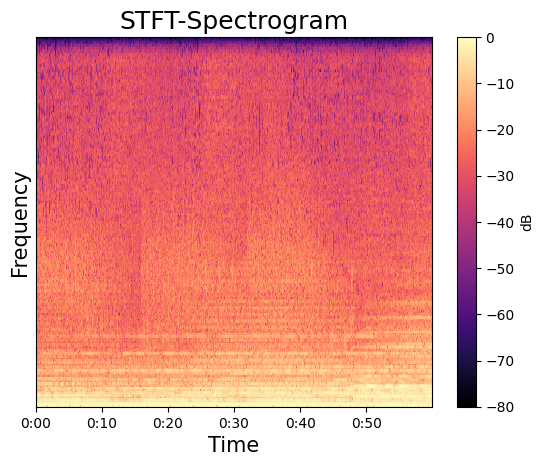

In [26]:
librosa.display.specshow(librosa.power_to_db(gen_spec, ref=np.max), sr=style_sr, x_axis="time", cmap="magma")
plt.colorbar(label="dB")
plt.title('STFT-Spectrogram', fontdict=dict(size=18))
plt.xlabel('Time', fontdict=dict(size=15))
plt.ylabel('Frequency', fontdict=dict(size=15))
plt.show()

In [ ]:
plt.plot(losses)
plt.show()

### MEL

In [7]:
method = "mel"

In [8]:
content_mat = utils.mel_wave_to_spectrum(content_wave, content_sr)
style_mat = utils.mel_wave_to_spectrum(style_wave, style_sr)
content_mat = torch.from_numpy(content_mat)[None, None, :, :].to(device)
style_mat = torch.from_numpy(style_mat)[None, None, :, :].to(device)

In [10]:
model = model_m.Random2DCNN()
model.eval()
model.to(device)

Random2DCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 1), stride=(1, 1))
  (LeakyReLU): LeakyReLU(negative_slope=0.2)
)

In [11]:
a_C_var = Variable(content_mat, requires_grad=False).float().to(device)
a_S_var = Variable(style_mat, requires_grad=False).float().to(device)
a_C = model(a_C_var)
a_S = model(a_S_var)

In [13]:
lr = 0.002
n_epochs = 20000
content_weight = 1e2
style_weight = 1

In [14]:
a_G_var = Variable(torch.randn(content_mat.shape) * 1e-3).to(device)
a_G_var.requires_grad = True

In [15]:
optimizer = torch.optim.Adam([a_G_var])

In [16]:
c_loss = 0
losses = []

In [17]:
for ep in range(1, n_epochs + 1):
    optimizer.zero_grad()
    a_G = model(a_G_var)

    content_loss = content_weight * utils.compute_content_loss(a_C, a_G)
    style_loss = style_weight * utils.compute_layer_style_loss(a_S, a_G)
    loss = content_loss + style_loss
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if ep % 1000 == 0:
        print(f"[Epoch {ep}/{n_epochs}] content_loss: {content_loss:.4f} style_loss: {style_loss:.4f}")

[Epoch 1000/20000] content_loss: 140388.4688 style_loss: 11659002880.0000
[Epoch 2000/20000] content_loss: 140240.0469 style_loss: 11355340800.0000
[Epoch 3000/20000] content_loss: 140240.6719 style_loss: 10917371904.0000
[Epoch 4000/20000] content_loss: 140359.6719 style_loss: 10376790016.0000
[Epoch 5000/20000] content_loss: 140579.5625 style_loss: 9754074112.0000
[Epoch 6000/20000] content_loss: 140890.0000 style_loss: 9064726528.0000
[Epoch 7000/20000] content_loss: 141284.2500 style_loss: 8322383360.0000
[Epoch 8000/20000] content_loss: 141757.4688 style_loss: 7540282368.0000
[Epoch 9000/20000] content_loss: 142305.7500 style_loss: 6731859968.0000
[Epoch 10000/20000] content_loss: 142925.5156 style_loss: 5910993920.0000
[Epoch 11000/20000] content_loss: 143613.2500 style_loss: 5092005376.0000
[Epoch 12000/20000] content_loss: 144365.0938 style_loss: 4289632256.0000
[Epoch 13000/20000] content_loss: 145176.6406 style_loss: 3518829568.0000
[Epoch 14000/20000] content_loss: 146042.60

In [18]:
gen_spec = a_G_var.cpu().data.numpy().squeeze()
gen_audio = utils.mel_spectrum_to_wave(gen_spec, content_sr)

In [19]:
utils.writefile(f"./inf_out2d_mel.wav", gen_audio, style_sr)

In [ ]:
utils.writefile(f"./gen_c_{method}_{content_weight}_{style_weight}_{content_file.parts[-1].split('.')[0]}_s{style_file.parts[-1].split('.')[0]}_{time.strftime("%m_%d_%H_%M_%S")}.wav", gen_audio, sr)

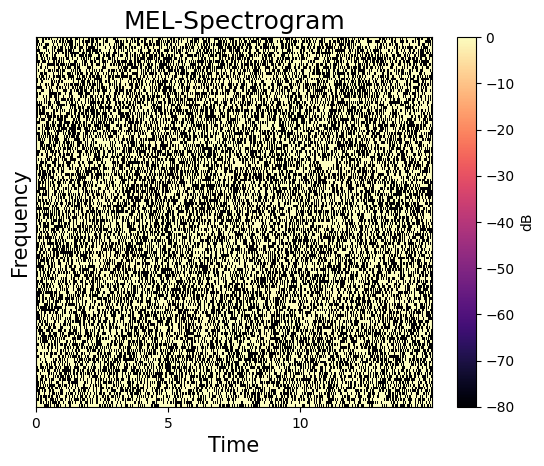

In [23]:
librosa.display.specshow(librosa.power_to_db(gen_spec, ref=np.max), sr=style_sr, x_axis="time", cmap="magma")
plt.colorbar(label="dB")
plt.title('MEL-Spectrogram', fontdict=dict(size=18))
plt.xlabel('Time', fontdict=dict(size=15))
plt.ylabel('Frequency', fontdict=dict(size=15))
plt.show()

In [ ]:
plt.plot(losses)
plt.show()

## 1d

In [27]:
N_FFT = 2048

In [28]:
from model import CNNModel, GramMatrix, StyleLoss
import copy
import torch.nn as nn

In [29]:
def read_audio_spectum(filename):
		x, fs = librosa.load(filename, duration=58.04) # Duration=58.05 so as to make sizes convenient
		S = librosa.stft(x, n_fft=N_FFT)
		p = np.angle(S)
		S = np.log1p(np.abs(S))  
		return S, fs

In [30]:
style_audio, style_sr = read_audio_spectum("./inf_style.mp3")
content_audio, content_sr = read_audio_spectum("./inf_source.mp3")

In [31]:
assert style_sr == content_sr

In [32]:
num_samples = style_audio.shape[1]
style_audio = style_audio.reshape([1,1025,num_samples])
content_audio = content_audio.reshape([1,1025,num_samples])

In [33]:
style_float = Variable((torch.from_numpy(style_audio)).cuda())
content_float = Variable((torch.from_numpy(content_audio)).cuda())	

In [34]:
cnn = CNNModel().cuda()
style_layers_default = ['conv_1']

In [35]:
style_weight=2500

In [36]:
def get_style_model_and_losses(cnn, style_float,style_weight=style_weight, style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)
    style_losses = []
    model = nn.Sequential()  # the new Sequential module network
    gram = GramMatrix()  # we need a gram module in order to compute style targets
    if torch.cuda.is_available():
        model = model.cuda()
        gram = gram.cuda()

    name = 'conv_1'
    model.add_module(name, cnn.cnn1)
    if name in style_layers:
        target_feature = model(style_float).clone()
        target_feature_gram = gram(target_feature)
        style_loss = StyleLoss(target_feature_gram, style_weight)
        model.add_module("style_loss_1", style_loss)
        style_losses.append(style_loss)
    return model, style_losses

In [37]:
input_float = content_float.clone()
learning_rate_initial = 0.03

In [38]:
def get_input_param_optimizer(input_float):
		input_param = nn.Parameter(input_float.data)
		optimizer = torch.optim.Adam([input_param], lr=learning_rate_initial, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
		return input_param, optimizer

In [39]:
num_steps= 2500

In [40]:
def run_style_transfer(cnn, style_float, input_float, num_steps=num_steps, style_weight=style_weight): #STYLE WEIGHT, NUM_STEPS
    print('Building the style transfer model..')
    model, style_losses = get_style_model_and_losses(cnn, style_float, style_weight)
    input_param, optimizer = get_input_param_optimizer(input_float)
    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:
        def closure():
            # correct the values of updated input image
            input_param.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_param)
            style_score = 0

            for sl in style_losses:
                style_score += sl.backward()

            run[0] += 1
            if run[0] % 100 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:8f}'.format(style_score.item())) #CHANGE 4->8 
                print()
            return style_score


        optimizer.step(closure)
    input_param.data.clamp_(0, 1)
    return input_param.data	

In [41]:
output = run_style_transfer(cnn, style_float, input_float)
if torch.cuda.is_available():
    output = output.cpu()

Building the style transfer model..
Optimizing..
run [100]:
Style Loss : 0.002002

run [200]:
Style Loss : 0.001999

run [300]:
Style Loss : 0.001988

run [400]:
Style Loss : 0.001939

run [500]:
Style Loss : 0.001903

run [600]:
Style Loss : 0.001891

run [700]:
Style Loss : 0.001886

run [800]:
Style Loss : 0.001883

run [900]:
Style Loss : 0.001882

run [1000]:
Style Loss : 0.001881

run [1100]:
Style Loss : 0.001880

run [1200]:
Style Loss : 0.001879

run [1300]:
Style Loss : 0.001879

run [1400]:
Style Loss : 0.001879

run [1500]:
Style Loss : 0.001879

run [1600]:
Style Loss : 0.001878

run [1700]:
Style Loss : 0.001878

run [1800]:
Style Loss : 0.001878

run [1900]:
Style Loss : 0.001878

run [2000]:
Style Loss : 0.001878

run [2100]:
Style Loss : 0.001878

run [2200]:
Style Loss : 0.001878

run [2300]:
Style Loss : 0.001878

run [2400]:
Style Loss : 0.001878

run [2500]:
Style Loss : 0.001878



In [42]:
output = output.squeeze(0).numpy()

In [43]:
a = np.exp(output) - 1

# This code is supposed to do phase reconstruction
p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
for i in range(500):
    S = a * np.exp(1j*p)
    x = librosa.istft(S)
    p = np.angle(librosa.stft(x, n_fft=N_FFT))

In [44]:
utils.writefile("inf_out1d.wav", x, style_sr)